In [3]:
import bz2
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from pylab import *
from sklearn.preprocessing import StandardScaler

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

In [4]:
DATA = '../../data/cluster/year/'
BUFFER = 5 # Number of cells around each cell to include

In [5]:
[tensor for tensor in os.listdir(DATA) if tensor.endswith('.bz2')]

['tensor2000.pkl.bz2',
 'tensor2001.pkl.bz2',
 'tensor2002.pkl.bz2',
 'tensor2003.pkl.bz2',
 'tensor2004.pkl.bz2',
 'tensor2005.pkl.bz2',
 'tensor2006.pkl.bz2',
 'tensor2007.pkl.bz2',
 'tensor2008.pkl.bz2',
 'tensor2009.pkl.bz2',
 'tensor2010.pkl.bz2',
 'tensor2011.pkl.bz2',
 'tensor2012.pkl.bz2',
 'tensor2013.pkl.bz2',
 'tensor2014.pkl.bz2',
 'y_matrix2000.pkl.bz2',
 'y_matrix2001.pkl.bz2',
 'y_matrix2002.pkl.bz2',
 'y_matrix2003.pkl.bz2',
 'y_matrix2004.pkl.bz2',
 'y_matrix2005.pkl.bz2',
 'y_matrix2006.pkl.bz2',
 'y_matrix2007.pkl.bz2',
 'y_matrix2008.pkl.bz2',
 'y_matrix2009.pkl.bz2',
 'y_matrix2010.pkl.bz2',
 'y_matrix2011.pkl.bz2',
 'y_matrix2012.pkl.bz2',
 'y_matrix2013.pkl.bz2',
 'y_matrix2014.pkl.bz2']

In [6]:
def load_xy(data_path, year, verbose=False):
    x_path = data_path + 'tensor%d.pkl.bz2' % year
    y_path = data_path + 'y_matrix%d.pkl.bz2' % year
    if verbose: print('\nLoading X tensor from %s' % x_path)
    X = pickle.load(bz2.open(x_path, 'rb'))
    if verbose: print('Loading y tensor from %s' % y_path)
    Y = pickle.load(bz2.open(y_path, 'rb'))
    
    if verbose:
        print('  X: ', X.shape, '(width, height, layers)')
        print('  Y: ', Y.shape, '    (width, height)')
    return X, Y

In [7]:
X_2000, Y_2000 = load_xy(DATA, 2000, verbose=True)


Loading X tensor from ../../data/cluster/year/tensor2000.pkl.bz2
Loading y tensor from ../../data/cluster/year/y_matrix2000.pkl.bz2
  X:  (188, 353, 19) (width, height, layers)
  y:  (188, 353)     (width, height)


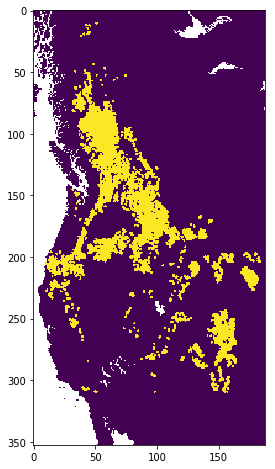

In [8]:
# Demonstrate accuracy
imshow(np.rot90(Y_2000));

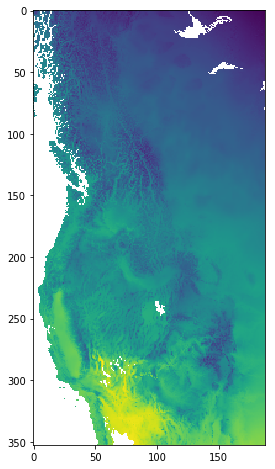

In [9]:
imshow(np.rot90(X_2000[:, :, 0]));

In [10]:
def load_xy_set(data_path, years, verbose=False):
    X_set = []
    Y_set = []
    
    for year in years:
        X, Y = load_xy(data_path, year, verbose)
        X_set.append(X)
        Y_set.append(Y)
    
    X = np.array(X_set)
    Y = np.array(Y_set)
    
    if verbose:
        print('\nX:', X.shape, '(years, width, height, layers)')
        print('Y:', Y.shape, '    (years, width, height)')

    return (X, Y)

In [11]:
test_years = range(2000, 2003)
valid_years = range(2003, 2006)
train_years = range(2006, 2015)

print('TRAINING DATA:')
train = load_xy_set(DATA, train_years, verbose=True)

print('\n\n\nVALIDATION DATA:')
valid = load_xy_set(DATA, valid_years, verbose=True)

print('\n\n\nTEST DATA:')
test  = load_xy_set(DATA, test_years, verbose=True)

TRAINING DATA:

Loading X tensor from ../../data/cluster/year/tensor2006.pkl.bz2
Loading y tensor from ../../data/cluster/year/y_matrix2006.pkl.bz2
  X:  (188, 353, 19) (width, height, layers)
  y:  (188, 353)     (width, height)

Loading X tensor from ../../data/cluster/year/tensor2007.pkl.bz2
Loading y tensor from ../../data/cluster/year/y_matrix2007.pkl.bz2
  X:  (188, 353, 19) (width, height, layers)
  y:  (188, 353)     (width, height)

Loading X tensor from ../../data/cluster/year/tensor2008.pkl.bz2
Loading y tensor from ../../data/cluster/year/y_matrix2008.pkl.bz2
  X:  (188, 353, 19) (width, height, layers)
  y:  (188, 353)     (width, height)

Loading X tensor from ../../data/cluster/year/tensor2009.pkl.bz2
Loading y tensor from ../../data/cluster/year/y_matrix2009.pkl.bz2
  X:  (188, 353, 19) (width, height, layers)
  y:  (188, 353)     (width, height)

Loading X tensor from ../../data/cluster/year/tensor2010.pkl.bz2
Loading y tensor from ../../data/cluster/year/y_matrix2010.

Summary:
```
Training:   X: (9, 188, 353, 19) (years, width, height, layers) (2006 - 2014, 80%)
Validation: X: (3, 188, 353, 19) (years, width, height, layers) (2003 - 2005, 20%)
Test:       X: (3, 188, 353, 19) (years, width, height, layers) (2000 - 2002, 20%) 
```

The goal now is, for each cell y, w, h (`year`, `width_location`, `height_location`) in the grid, create a _single_ X input that is a submatrix of shape (1, 2 * buffer + 1, 2 * buffer + 1, layers), namely:<br/>
`X[year, w - buffer:w + buffer, h - buffer:h + buffer, :]`.<br/>
To simplify edge cases, we will simply discard those locations within `buffer` cells from any edge.<br/>
The output X will be of shape:<br/>
`(m, 2*buffer + 1, 2*buffer + 1, 19)`, where `m` is the number of training examples: <br/>
`m = years * (width - 2*buffer) * (height - 2*buffer)`.


However, because the data sets are too large to hold in memory, create instead, a function to create a random mini-batch instead, where `m` is the `batch_size`.

In [58]:
def get_batch(train, valid, batch_size, buffer_size=5, is_X=True):

    def get_half_batch(data):
        X_data, Y_data = data
        years, width, height, layers = X_data.shape
        mX, mY = [], []

        while len(mX) < batch_size:
            yr = np.random.choice(range(years))
            w = np.random.choice(range(buffer_size, width - buffer_size))
            h = np.random.choice(range(buffer_size, height - buffer_size))
            candidate = X_data[yr, 
                               w - buffer_size:w + buffer_size + 1, 
                               h - buffer_size:h + buffer_size + 1, 
                               :]
            if sum(np.isnan(candidate)) == 0:
                mX.append(candidate)
                mY.append(Y_data[yr, w, h])
        return mX, mY
    
    mX_train, mY_train = get_half_batch(train)
    mX_valid, mY_valid = get_half_batch(valid)
        
    return ((np.array(mX_train), np.array(mY_train)), 
            (np.array(mX_valid), np.array(mY_valid)))

In [59]:
(mx_train, my_train), (mx_valid, my_valid) = get_batch(
    train, valid, 32, BUFFER)
print(mx_train.shape, my_train.shape)
print(mx_valid.shape, my_valid.shape)

(32, 11, 11, 19) (32,)
(32, 11, 11, 19) (32,)


1.0
0.0


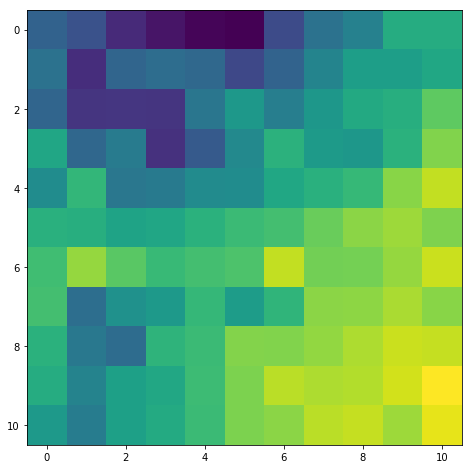

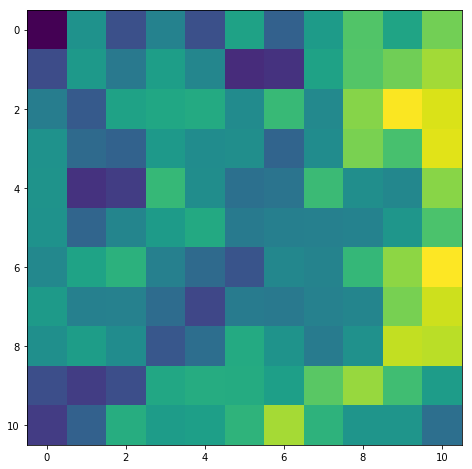

In [63]:
yr = np.random.choice(range(32))
layer = np.random.choice(range(19))
print(my_train[i])
imshow(np.rot90(mx_train[i, :, :, layer]));

print(my_valid[i])
figure();
imshow(np.rot90(mx_valid[i, :, :, layer]));